## 1. Celem tego notatnika jest zbadanie możliwości autentykacji użytkownika na podstawie sygnałów EEG (fal mózgowych), które zostały zebrane przy użyciu urządzenia MindWave Mobile 2. Zadaniem klasyfikacyjnym jest określenie, czy prezentowany bodziec wizualny był znany użytkownikowi na podstawie jego reakcji mózgowej.

##### Wczytanie bibliotek i danych

In [35]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PROJECT_ROOT = Path().resolve().parents[0]  
df = pd.read_csv(PROJECT_ROOT / "data/autentykacja_eeg.csv", sep=';')
df.head()

,Flag,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength
0,1,262466,17013,25803,16111,2057,3064,1616,3629,0,0,-1
1,1,156671,5978,2173,1203,1025,591,361,121,0,0,-1
2,1,420205,9451,2731,3809,1719,4884,2811,1304,0,0,-1
3,1,1011946,57480,4534,10354,7409,2815,5016,1030,0,0,-1
4,1,937903,225754,88704,38777,12663,16150,15275,7426,34,51,-1


## 2. EDA

##### Opis danych:
- Każdy wiersz to jeden odczyt EEG w odpowiedzi na bodziec wizualny.
- Kolumna Flag: 1 = bodziec znany, 0 = bodziec nieznany.
- BlinkStrength: siła mrugnięcia (lub -1 jeśli brak).
- Pozostałe kolumny zawierają cechy EEG: Attention, Meditation, oraz pasma fal mózgowych (Delta, Theta, itd.).

##### Statystyki opisowe

In [37]:
df.describe()

,Flag,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength
count,7488.000000,7.488000e+03,7.488000e+03,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000,7488.000000
mean,0.561832,3.057571e+05,6.203814e+04,15488.460337,12827.290465,10501.763221,8722.354300,6498.413061,3138.050347,52.853232,59.330529,11.113782
std,0.496195,4.912833e+05,1.136191e+05,29270.995706,21890.222896,20775.034225,15576.102166,9513.537049,4794.297045,20.040042,18.510044,27.602990
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,1.946475e+04,1.181000e+04,3087.500000,3157.000000,2700.000000,2516.000000,1564.750000,756.000000,40.000000,48.000000,-1.000000
50%,1.000000,7.908500e+04,2.672700e+04,7116.000000,6684.000000,5539.000000,5261.000000,3560.000000,1719.000000,53.000000,60.000000,-1.000000
75%,1.000000,3.889475e+05,6.359675e+04,16240.250000,13810.000000,11469.250000,10493.000000,8017.750000,3786.000000,66.000000,70.000000,-1.000000
max,1.000000,3.847250e+06,2.072669e+06,560568.000000,574992.000000,812576.000000,831441.000000,200491.000000,100787.000000,100.000000,100.000000,255.000000


##### balans klas

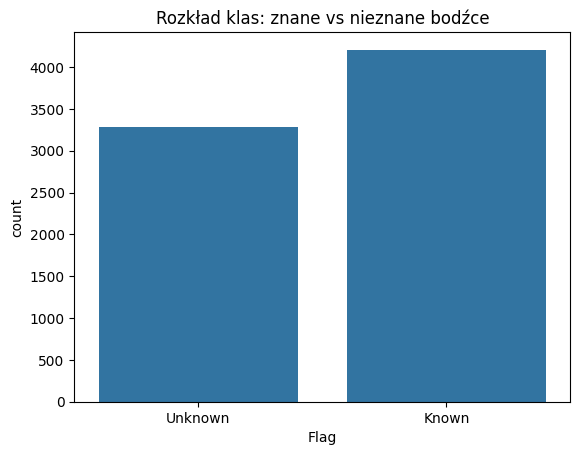

In [39]:
sns.countplot(x="Flag", data=df)
plt.title("Rozkład klas: znane vs nieznane bodźce")
plt.xticks([0, 1], ["Unknown", "Known"])
plt.show()

##### W celu poradzenia sobię z brakującymi wartościami mrugnięcia zastąpiono te dane medianą

In [43]:
if (df["BlinkStrength"] == -1).any():
        blink_median = df.loc[df["BlinkStrength"] != -1, "BlinkStrength"].median()
        df["BlinkStrength"] = df["BlinkStrength"].replace(-1, blink_median)
df.head(n = 10)

,Flag,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength
0,1,262466,17013,25803,16111,2057,3064,1616,3629,0,0,56
1,1,156671,5978,2173,1203,1025,591,361,121,0,0,56
2,1,420205,9451,2731,3809,1719,4884,2811,1304,0,0,56
3,1,1011946,57480,4534,10354,7409,2815,5016,1030,0,0,56
4,1,937903,225754,88704,38777,12663,16150,15275,7426,34,51,56
5,1,778863,302268,11871,58241,32758,61322,32156,6088,40,40,56
6,1,77880,35779,3652,6341,6655,3018,974,1079,38,30,56
7,1,149627,16884,4242,4484,5116,3295,2897,1968,41,37,51
8,1,85213,8680,2364,797,1570,1836,1647,279,53,21,56
9,1,627194,102265,15012,16021,30043,3514,7110,1281,35,27,39


##### Podsumowanie przetwarzania danych
- Wartości BlinkStrength == -1 zostały zastąpione medianą z wartości niepustych.
- Opcjonalnie dodano nową cechę binarną BlinkDetected, informującą czy wykryto mrugnięcie.
- Przed uczeniem sieci neuronowych dane zostały wystandaryzowane (StandardScaler).

##### Proces trenowania modelu MLP

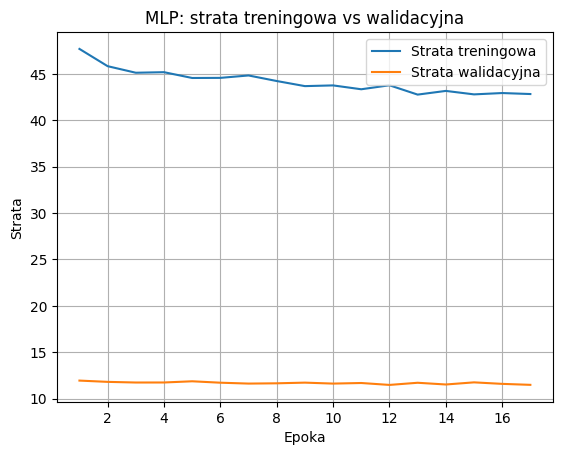

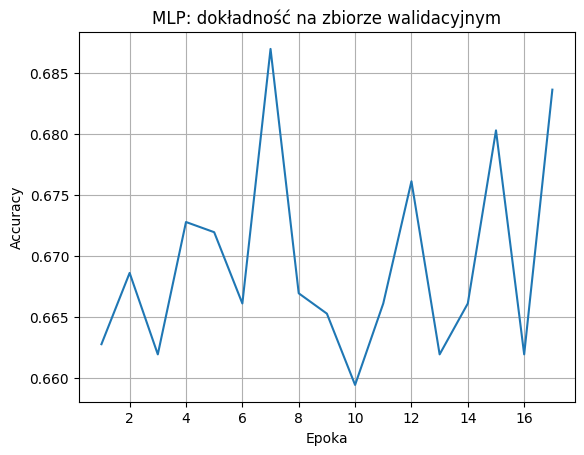

In [45]:
log = pd.read_csv(PROJECT_ROOT / "outputs/mlp_training_log.csv")

# 5. Krzywe uczenia MLP
# =======================
plt.plot(log["epoch"], log["train_loss"], label="Strata treningowa")
plt.plot(log["epoch"], log["val_loss"], label="Strata walidacyjna")
plt.title("MLP: strata treningowa vs walidacyjna")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid()
plt.show()

plt.plot(log["epoch"], log["val_accuracy"], label="Dokładność walidacyjna")
plt.title("MLP: dokładność na zbiorze walidacyjnym")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## 3. Wyniki modeli

In [48]:
results = pd.DataFrame({
    "Model": [
        "Random Forest", "MLP"
    ],
    "Accuracy": [0.8264, 0.6844],
})

results = results.sort_values("Accuracy", ascending=False)
results.style.background_gradient(cmap="Greens")

,Model,Accuracy
0,Random Forest,0.826400
1,MLP,0.684400


##### Wyniki z dodaniem cechy BlinkDetect

In [49]:
results = pd.DataFrame({
    "Model": [
        "Random Forest", "MLP"
    ],
    "Accuracy": [0.8271, 0.6627],
})

results = results.sort_values("Accuracy", ascending=False)
results.style.background_gradient(cmap="Greens")

,Model,Accuracy
0,Random Forest,0.827100
1,MLP,0.662700


## 4. Wnioski
- Random Forest uzyskał lepsze wyniki niż MLP, co prawdopodobnie wynika z małej liczby danych.
- MLP miało trudności z generalizacją mimo zastosowania balansu klas, dropoutu i early stoppingu. Osobiście nie jestem pewien czy model MLP został poprawnie zaimplementowany także też, to może mieć wpływ na słabe wyniki.
- Dane EEG są z natury szumne i trudne w interpretacji. Sieci neuronowe wymagają większej liczby przykładów, aby wyłapać złożone wzorce.
- Dodanie cechy BlinkDetected nie przyniosło istotnej poprawy.
- Problem niezbalansowanych klas częściowo został zaadresowany przez wagowanie w funkcji straty.
